In [10]:
# Load library
library("tidyverse")
library("weights")
tick_size  =  1.5
label_size = 2

In [11]:
library(latex2exp)

#To get statistics from the summary data

load("compiled_data_corrected.Rdata");
new.data$rel_v = NULL
jacob = read.table("haplotypes-quality-filtered-final-drop-Point01-Strain-collapse-point94-relatedness.tab", header=T, sep="\t", stringsAsFactors=F)
discard.samples = unique(jacob$isolate[jacob$discarded])

pops<-unique(new.data$Pop);
cont<-new.data$group[match(pops, new.data$Pop)];
af<-pops[grep("Afr", cont)];
as<-pops[grep("Asi", cont)];
cont.label<-rep(1, length(pops));
cont.label[pops %in% af]<-2;

#Average MI rate per population
op<-array(0, c(length(pops), 11));
colnames(op)<-c("Mean.K", "Mean.KG1", "Mean.KG2", "Mean.KE2",
	"Mean.rel.dual", "Mean.rel.triplus", "N", "N2", "NG2", "Mean.IBD", "Mean.IBD.filtered");
for (i in 1:length(pops)) {
	wi<-which(new.data$Pop==pops[i]);
	tmp<-new.data[wi,];
	op[i,1:4]<-c(mean(new.data$Est_K[wi]), mean(new.data$Est_K[wi]>1), mean(new.data$Est_K[wi]>2), mean(new.data$Est_K[wi]==2));
	op[i,5]<-mean(tmp$rel[tmp$Est_K==2]);
	op[i,6]<-mean(tmp$rel[tmp$Est_K>2]);
	op[i,7]<-nrow(tmp);
	op[i,8]<-sum(tmp$Est_K==2);
	op[i,9]<-sum(tmp$Est_K>2);
	op[i,10]<-mean(tmp$rel, na.rm=T);
        tmp = tmp[!tmp$ID %in% discard.samples,]
        op[i,11]<-mean(tmp$rel, na.rm=T);
}


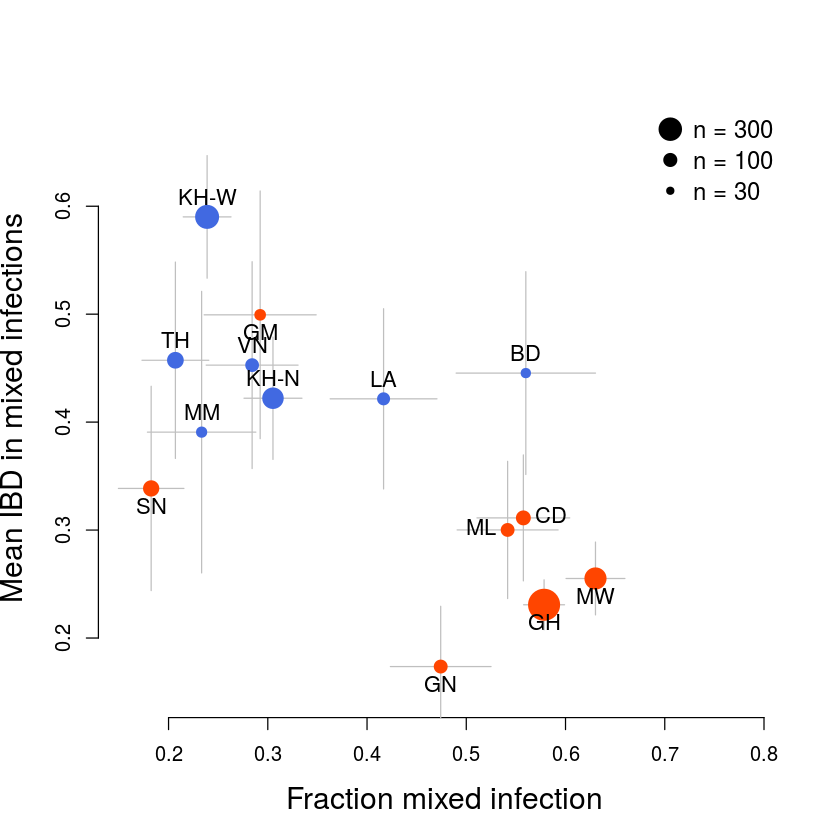

In [12]:
#Correlations and summary plot
labs<-c("TH", "KH-W", "KH-N", "VN", "LA", "BD", "MM", "MW", "CD", "GH", "ML", "SN", "GM", "GN");
plot(op[,2], op[,10], type="n", col=c("blue", "red")[cont.label], pch=19,
	xlab="Fraction mixed infection",
	ylab="Mean IBD in mixed infections",
#	xlim=c(min(op[,2])*0.85, max(op[,2])*1.15),
	xlim=c(min(op[,2])*0.85, .8),
	ylim=c(min(op[,10])*0.85, max(op[,10])*1.15),
	bty="n",
	main="", cex.lab = 1.5
);

sex<-sqrt(op[,2]*(1-op[,2])/op[,7]);
sey<-sqrt(op[,10]*(1-op[,10])/(op[,8]+op[,9]));
fac<-1;
segments(op[,2]-fac*sex, op[,10], op[,2]+fac*sex, op[,10], col=grey(0.75));
segments(op[,2], op[,10]-fac*sey, op[,2], op[,10]+fac*sey, col=grey(0.75));
points(op[,2], op[,10], col=c("royalblue", "orangered1")[cont.label], pch=19, cex = sqrt(op[,7])/7)

text(x=op[,2], y=op[,10], labels=labs, cex=1.1, pos=c(3, 3, 3, 3, 3, 3, 3, 1, 4, 1, 2, 1, 1, 1)); #c(3,1)[cont.label]
ss = c(300, 100, 30)
legend("topright", legend = paste("n =", ss), pch = 19, pt.cex = sqrt(ss)/7, cex = 1.2, bty = "n")


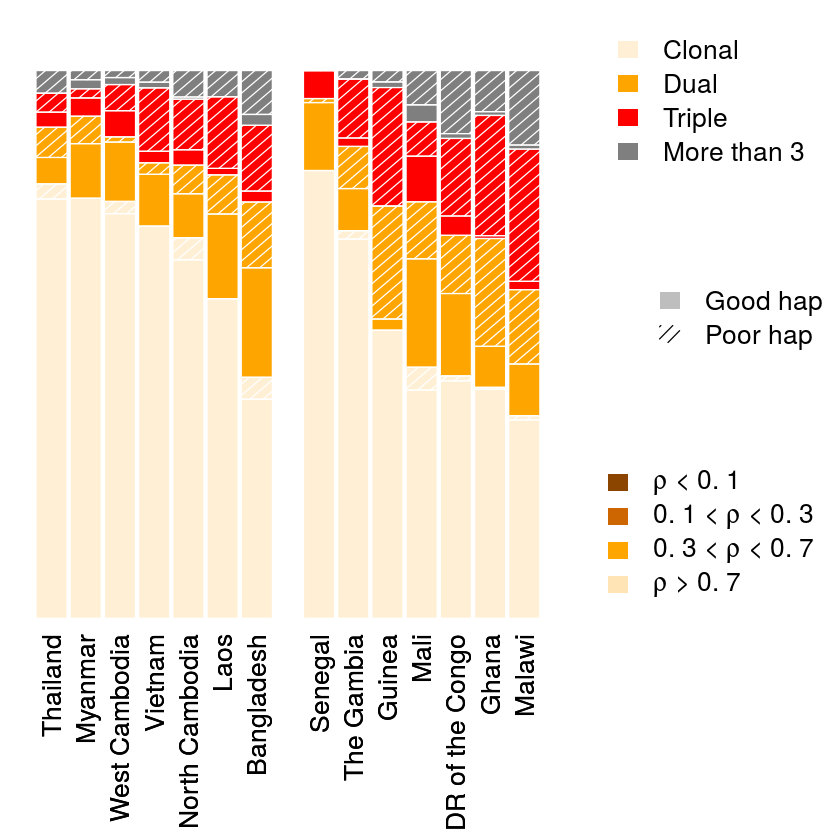

In [13]:
tab<-array(0, c(length(pops), 4));
tab.all<-array(0, c(length(pops), 4));
tab.ct<-array(0, c(length(pops), 4));
tab.ct.good<-array(0, c(length(pops), 4));

tab.seperated <-array(0, c(length(pops), 8)); # count the good and bad haplotypes separately

for (i in 1:length(pops)) {
	tmp<-new.data[new.data$Pop == pops[i],];
	tab[i,]<-c(mean(tmp$Est_K==1), mean(tmp$Est_K==2), mean(tmp$Est_K==3), mean(tmp$Est_K==4));
        tab.all[i,]<-c(length(tmp$Est_K==1), length(tmp$Est_K==2), length(tmp$Est_K==3), length(tmp$Est_K==4));
        tab.ct[i,]<-c(sum(tmp$Est_K==1), sum(tmp$Est_K==2), sum(tmp$Est_K==3), sum(tmp$Est_K==4));
        tmp = tmp[!tmp$ID %in% discard.samples,]
        tab.ct.good[i,]<-c(sum(tmp$Est_K==1), sum(tmp$Est_K==2), sum(tmp$Est_K==3), sum(tmp$Est_K==4));
        tab.seperated[i,] = as.numeric(rbind(tab.ct.good[i,],tab.ct[i,]-tab.ct.good[i,])/tab.all[i,])
}
c1<-which(cont.label==1);
c2<-which(cont.label==2);
oo<-c(c1[order(tab[c1,1], decreasing=T)], c2[order(tab[c2,1], decreasing=T)]);
#oo<-c(c1[order(tab[c1,1], decreasing=T)], c2[order(tab[c2,1], decreasing=T)]);

        par(mfrow=c(1,2));
sp<-c(rep(0.1, length(c1)), 1, rep(0.1, length(c2)-1));

par(mar = c(14, 1, 1, 0))
layout(matrix(c(1,1,2), 1, 3, byrow = TRUE))
v<-barplot(t(tab[oo,]),
	names=gsub("_", " ", pops[oo]),
	cex.names=2, las=2, yaxt="n",
	col=c("papayawhip", "orange", "red", "grey50"),
	ylim=c(0,1.1),
	border=NA,
	space=sp
);

barplot(t(tab.seperated[oo,]),
	names=gsub("_", " ", pops[oo]),
	cex.names=2, las=2, yaxt="n",
	col="white",
	ylim=c(0,1.1),
	border= "white",
	space=sp,
        angle=40, density=c(0,15),
        add = T
);

plot(0,0,type="n", xlab="", ylab="", xaxt="n", yaxt="n", xlim=c(0,10), ylim=c(0,10), bty="n");
legend("top", legend=c("Clonal", "Dual", "Triple", "More than 3"), fill=c("papayawhip", "orange", "red", "grey50"),
	bty="n", border=NA, cex = 2);
legend("right", legend=c("Good hap", "Poor hap"), fill=c("gray", "black"),
           density=c(NA, 15), bty="n", border=NA, cex = 2);
legend("bottom", legend=c(TeX("$\\rho$ < 0.1"), TeX("0.1 < $\\rho$ < 0.3"), TeX("0.3 < $\\rho$ < 0.7"), TeX("$\\rho$ > 0.7")), fill=c("darkorange4", "darkorange3", "orange", "moccasin"),
	bty="n", border=NA, cex = 2);


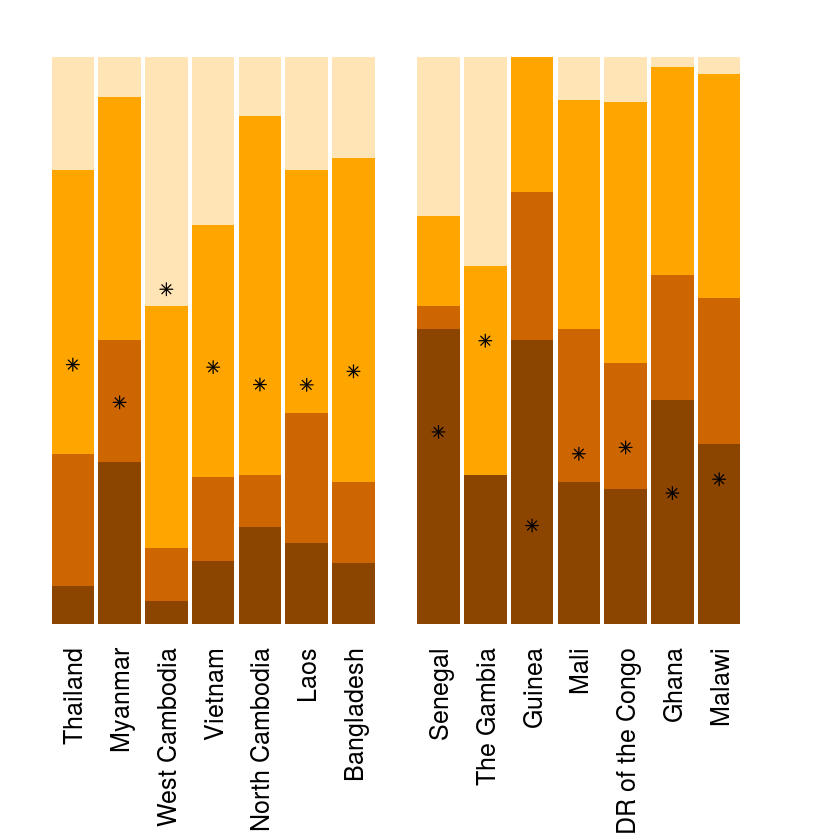

In [14]:
tab<-array(0, c(length(pops), 4));
for (i in 1:length(pops)) {
	tmp<-new.data[new.data$Pop == pops[i],];
	tab[i,]<-c(mean(tmp$rel<=0.1, na.rm=T),
		mean(tmp$rel>0.1 & tmp$rel<=0.3, na.rm=T),
		mean(tmp$rel>0.3 & tmp$rel<=0.7, na.rm=T),
		mean(tmp$rel>0.7, na.rm=T));
}

par(mar = c(9, 1, 0, 3))
v<-barplot(t(tab[oo,]),
	names=gsub("_", " ", pops[oo]),
	cex.names=1.25, las=2, yaxt="n",
	col=c("darkorange4", "darkorange3", "orange", "moccasin"),
	ylim=c(0,1.1),
	border=NA,
	space=sp
);
#axis(4, at = seq(0, 1, length.out = 5), labels = seq(0,1, length.out =5), las =1)
points(v,op[oo,10], pch = 8)


In [15]:
simulation_error = read.table("simulation_error.txt", header=T)
all.nonIBD.error = simulation_error %>% filter(., method == "nonIBD")
all.IBD.error = simulation_error %>% filter(., method == "IBD")

group_by(all.IBD.error, case_panel) %>% 
    summarise(., mean(genotypError)) %>% 
    filter(., grepl("first25", case_panel))

group_by(all.nonIBD.error, case_panel) %>% 
    summarise(., mean(genotypError)) %>% 
    filter(., grepl("first75percentSame.25v75", case_panel))

group_by(all.IBD.error, case_panel) %>% 
    summarise(., mean(genotypError)) %>% 
    filter(., grepl("first75percentSame.25v75", case_panel))


case_panel,mean(genotypError)
first25percentSame.25v75,0.004110415
first25percentSame.45v55,0.010239353


case_panel,mean(genotypError)
first75percentSame.25v75,0.005814257


case_panel,mean(genotypError)
first75percentSame.25v75,0.00384954


In [16]:
plot_error_ecdf <- function(){
par(mar = c(5,5,2,2))

plot(c(0,1), c(0,1), xlim = c(0,.05), ylim = c(0, 1), type=  "n", 
     xlab = "Genotype Error", ylab = "Cumulative frequencies", 
     cex.axis = tick_size, cex.lab = label_size)
x = seq(0, 0.05, length.out = 100)
col.ary = c("blue", "green", "red")
col.ct = 1
for (case in paste("first", c(25, 50, 75), "percentSame", sep ="")){
    for (panel in c("25v75")){
#    for (panel in c("25v75", "45v55")){
        tmp.case.panel = paste(case, ".", panel, sep ="")
        tmp.data.nonIBD = filter(all.nonIBD.error, case_panel == tmp.case.panel)
        ecdf.nonIBD = ecdf(tmp.data.nonIBD$genotypError)
        tmp.data.IBD = filter(all.IBD.error, case_panel == tmp.case.panel)
        ecdf.IBD = ecdf(tmp.data.IBD$genotypError)

        lines(x, ecdf.nonIBD(x), col = col.ary[col.ct], lty = 1, lwd = 2)
        lines(x, ecdf.IBD(x), col = col.ary[col.ct], lty = 2, lwd = 2)
    }
    col.ct = col.ct + 1
}
legend("right", legend = c("DEploidIBD", "DEploid"), lty = c(2, 1), 
       lwd = 2, bty = "n", cex = label_size)
legend("bottomright", pch = 16, legend = c("Low relatedness",
                                           "Moderate relatedness",
                                           "High relatedness"), 
       col = 4:2, text.col = par("fg"), cex = label_size, bty = "n")
}

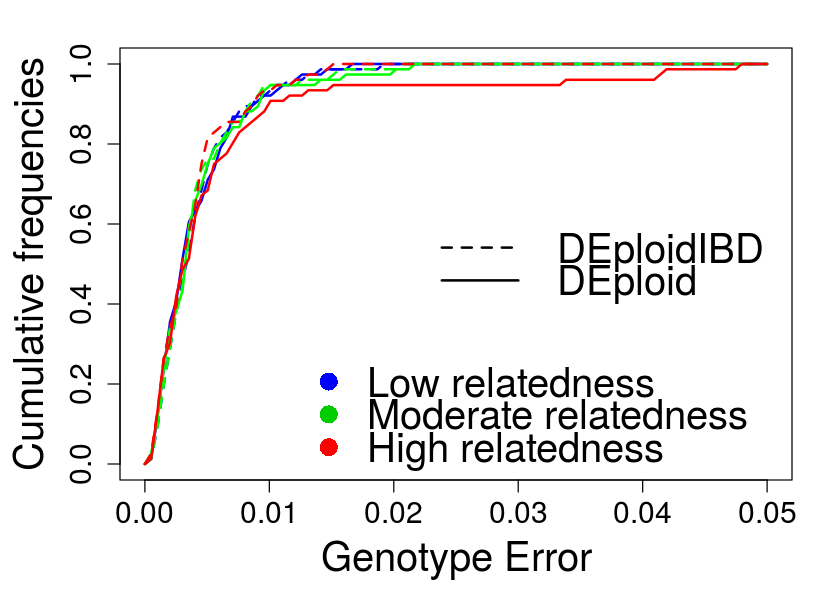

In [17]:
options(repr.plot.width=7, repr.plot.height=5)
plot_error_ecdf ()